In [ ]:
# Install necessary libraries
!pip install numpy matplotlib scikit-learn seaborn tensorflow

In [142]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Preprocessing

In [73]:
#load the datasets
train_img = np.load('./quickdraw_subset_np/train_images.npy')
train_lab = np.load('./quickdraw_subset_np/train_labels.npy')
test_img = np.load('./quickdraw_subset_np/test_images.npy')
test_lab = np.load('./quickdraw_subset_np/test_labels.npy')

In [53]:
num_classes = 5
train_images = train_img.reshape(train_img.shape[0], -1).T / 255.0  # Flatten and normalize
test_images = test_img.reshape(test_img.shape[0], -1).T / 255.0

In [54]:
glove_vocab ='./GloVe-master/vocab.txt'
glove_vectors ='./GloVe-master/vectors.txt'
categories =['rabbit', 'yoga', 'hand','snowman','motorbike']
label_mapping = {
    0: 'rabbit',
    1: 'yoga', 
    2: 'hand',
    3: 'snowman',
    4: 'motorbike'
}

# Then create the numerical indices
categories = ['rabbit', 'yoga', 'hand', 'snowman', 'motorbike']
train_labels = np.array([categories.index(label_mapping[l]) for l in train_lab])
test_labels = np.array([categories.index(label_mapping[l]) for l in test_lab])

In [149]:
def extract_glove_embeddings(target_words, glove_path='vectors.txt'):
    """
    Extract GloVe embeddings for specific target words.
    
    Args:
        target_words (list): List of words to extract embeddings for
        glove_path (str): Path to the GloVe vectors file
        
    Returns:
        dict: Dictionary mapping words to their embeddings (as numpy arrays)
    """
    word_vectors = {}
    target_set = set(target_words)  # For faster lookups
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in target_set:
                vector = [float(x) for x in parts[1:]]
                word_vectors[word] = vector
    
    # Check for missing words
    missing_words = [word for word in target_words if word not in word_vectors]
    if missing_words:
        print(f"Warning: Could not find embeddings for: {missing_words}")
    
    return word_vectors


embeddings1 = extract_glove_embeddings(categories, glove_vectors)
embeddings=embeddings1

In [94]:
# Define the substitutions
substitutions = {
    0: 'rabbit',
    1: 'yoga',
    2: 'hand',
    3: 'snowman',
    4: 'motorbike'
}

text_embeddings=embeddings
# Reverse mapping (word: number)
text_to_num = {v: k for k, v in substitutions.items()}

# Create sorted dictionary by numerical key
embeddings = {
    num: embeddings[word] 
    for num, word in sorted(substitutions.items()) 
    if word in embeddings
}

print(embeddings)

{0: [0.609324, -0.022543, 0.011828, -0.706884, 0.176127, -0.393985, 0.37986, 0.249944, -0.167537, -0.134852, -0.051388, -0.287825, 0.350833, -0.304678, -0.290927, -1.073358, 0.352563, 0.364154, -0.400473, 0.418211, -0.119981, -0.037377, -0.80465, -0.541993, 1.016055, 0.132862, 0.100789, 1.353594, -1.572245, -0.199049, 0.642179, -0.021891, 0.068152, -0.22076, -0.748127, 0.489734, 1.555667, 0.18175, -0.409515, 0.379901, -0.054096, -0.121948, 0.047241, 0.227744, 0.562062, 0.252324, 0.517244, -0.537666, -0.291284, -0.706507], 1: [-1.376016, 0.041353, 0.156007, 0.496281, -0.066054, 1.413051, 1.011795, 0.154465, -0.051993, 0.25226, -1.170333, 0.363874, 0.385269, 0.312886, 0.030601, 0.611984, -1.048806, 0.863274, -1.413643, -1.381114, 0.539365, 0.349213, 0.254117, -0.472865, 0.316274, -0.365676, -0.274885, -0.165729, -0.641214, -0.130244, -0.095079, 0.928912, 0.182513, -0.105189, -0.834605, 0.733241, 1.186343, 0.292818, -0.109281, 0.180187, 0.02251, 0.116141, 0.891353, -0.419105, -0.312739, 0

## No library implementation

In [95]:
class MLP:
    def __init__(self, input_size1, layer_specs1, input_size2, layer_specs2, momentum=0.9):
        """
        Initialize MLP with custom activation functions for each layer.
        
        Args:
            input_size1: Size of image input features
            layer_specs1: List of tuples [(size1, 'activation1'), ...] for image MLP
            input_size2: Size of word embedding input
            layer_specs2: List of tuples [(size1, 'activation1'), ...] for text MLP
            momentum: Momentum parameter for gradient descent
        """
        self.input_size1 = input_size1
        self.layer_specs1 = layer_specs1
        self.num_layers1 = len(layer_specs1)
        
        self.input_size2 = input_size2
        self.layer_specs2 = layer_specs2
        self.num_layers2 = len(layer_specs2)
        
        self.momentum = momentum

        # Initialize weights and biases for image MLP with He initialization
        sizes1 = [input_size1] + [size for size, _ in layer_specs1]
        self.weights1 = [np.random.randn(sizes1[i], sizes1[i-1]) * np.sqrt(2./sizes1[i-1]) 
                        for i in range(1, len(sizes1))]
        self.biases1 = [np.zeros((sizes1[i], 1)) for i in range(1, len(sizes1))]
        self.velocities_W1 = [np.zeros_like(w) for w in self.weights1]
        self.velocities_b1 = [np.zeros_like(b) for b in self.biases1]

        # Initialize weights and biases for text MLP with He initialization
        sizes2 = [input_size2] + [size for size, _ in layer_specs2]
        self.weights2 = [np.random.randn(sizes2[i], sizes2[i-1]) * np.sqrt(2./sizes2[i-1]) 
                        for i in range(1, len(sizes2))]
        self.biases2 = [np.zeros((sizes2[i], 1)) for i in range(1, len(sizes2))]
        self.velocities_W2 = [np.zeros_like(w) for w in self.weights2]
        self.velocities_b2 = [np.zeros_like(b) for b in self.biases2]

    def forward1(self, X):
        """Forward pass for image MLP"""
        self.activations1 = [X]
        self.Zs1 = []
        
        for i in range(self.num_layers1):
            W = self.weights1[i]
            b = self.biases1[i]
            Z = np.dot(W, self.activations1[-1]) + b
            self.Zs1.append(Z)
            
            activation_name = self.layer_specs1[i][1]
            if activation_name == 'relu':
                A = self.relu(Z)
            elif activation_name == 'sigmoid':
                A = self.sigmoid(Z)
            elif activation_name == 'linear':
                A = Z
            else:
                raise ValueError(f"Unknown activation: {activation_name}")
                
            self.activations1.append(A)
            
        return self.activations1[-1]

    def forward2(self, X):
        """Forward pass for text MLP"""
        self.activations2 = [X]
        self.Zs2 = []
        
        for i in range(self.num_layers2):
            W = self.weights2[i]
            b = self.biases2[i]
            Z = np.dot(W, self.activations2[-1]) + b
            self.Zs2.append(Z)
            
            activation_name = self.layer_specs2[i][1]
            if activation_name == 'relu':
                A = self.relu(Z)
            elif activation_name == 'sigmoid':
                A = self.sigmoid(Z)
            elif activation_name == 'linear':
                A = Z
            else:
                raise ValueError(f"Unknown activation: {activation_name}")
                
            self.activations2.append(A)
            
        return self.activations2[-1]

    def forward(self, X1, X2):
        """Forward pass for both MLPs"""
        out1 = self.forward1(X1)
        out2 = self.forward2(X2)
        return out1, out2

    def backward(self, X1, X2, Y, learning_rate):
        """
        Backpropagation through both networks.
        Y: one-hot encoded labels (num_classes, batch_size)
        """
        batch_size = X1.shape[1]
        
        # Forward pass to ensure activations are set
        image_emb, text_emb = self.forward(X1, X2)
        
        # Compute gradients of loss w.r.t. outputs
        dL_dF = (image_emb - text_emb) / batch_size  # L2 loss gradient
        dL_dG = (text_emb - image_emb) / batch_size  # L2 loss gradient
        
        # Backprop through image MLP
        dA = dL_dF
        for i in reversed(range(self.num_layers1)):
            activation_name = self.layer_specs1[i][1]
            
            if activation_name == 'relu':
                dZ = dA * self.relu_derivative(self.Zs1[i])
            elif activation_name == 'sigmoid':
                dZ = dA * self.sigmoid_derivative(self.activations1[i+1])
            elif activation_name == 'linear':
                dZ = dA
            else:
                raise ValueError(f"Unknown activation: {activation_name}")
                
            dW = np.dot(dZ, self.activations1[i].T)
            db = np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(self.weights1[i].T, dZ)
            
            # Update with momentum
            self.velocities_W1[i] = self.momentum * self.velocities_W1[i] + dW
            self.velocities_b1[i] = self.momentum * self.velocities_b1[i] + db
            
            self.weights1[i] -= learning_rate * self.velocities_W1[i]
            self.biases1[i] -= learning_rate * self.velocities_b1[i]
        
        # Backprop through text MLP
        dA = dL_dG
        for i in reversed(range(self.num_layers2)):
            activation_name = self.layer_specs2[i][1]
            
            if activation_name == 'relu':
                dZ = dA * self.relu_derivative(self.Zs2[i])
            elif activation_name == 'sigmoid':
                dZ = dA * self.sigmoid_derivative(self.activations2[i+1])
            elif activation_name == 'linear':
                dZ = dA
            else:
                raise ValueError(f"Unknown activation: {activation_name}")
                
            dW = np.dot(dZ, self.activations2[i].T)
            db = np.sum(dZ, axis=1, keepdims=True)
            dA = np.dot(self.weights2[i].T, dZ)
            
            # Update parameters with momentum
            self.velocities_W2[i] = self.momentum * self.velocities_W2[i] + dW
            self.velocities_b2[i] = self.momentum * self.velocities_b2[i] + db
            
            self.weights2[i] -= learning_rate * self.velocities_W2[i]
            self.biases2[i] -= learning_rate * self.velocities_b2[i]

    def loss(self, out1, out2, truth):
        """
        Compute loss between image and text embeddings.
        truth: one-hot encoded labels (num_classes, batch_size)
        """
        batch_size = out1.shape[1]
        
        # L2 distance between matching pairs
        distances = np.sum((out1 - out2)**2, axis=0)
        loss = np.sum(distances * truth.any(axis=0)) / batch_size
        
        return loss

    def evaluate(self, X, Y, text_embeddings):
        """Evaluate model on given data"""
        # Get batch of text embeddings
        text_batch = np.dot(text_embeddings, Y)
        
        # Forward pass
        out1, out2 = self.forward(X, text_batch)
        
        # Calculate loss
        loss = self.loss(out1, out2, Y)
        
        # Calculate accuracy
        predictions = self.predict(X, text_embeddings)
        true_labels = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == true_labels)
        
        return loss, accuracy

    

    def predict(self, X, text_embeddings):
        """Predict category by finding closest text embedding"""
        # Get image embeddings (shape: [embed_dim, num_images])
        image_emb = self.forward1(X)
        
        # Get text embeddings (shape: [embed_dim, num_classes])
        text_emb = self.forward2(text_embeddings)
        
        # Compute cosine similarities (transpose one matrix for correct multiplication)
        similarities = np.dot(text_emb.T, image_emb)  # shape: [num_classes, num_images]
        
        return np.argmax(similarities, axis=0)

    # Activation functions
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def sigmoid_derivative(self, A):
        return A * (1 - A)
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [137]:
# Prepare data (same as before)
train_images = train_img.reshape(train_img.shape[0], -1).T / 255.0
test_images = test_img.reshape(test_img.shape[0], -1).T / 255.0

# Convert labels to one-hot encoding
num_classes = len(embeddings)
train_labels = np.eye(num_classes)[train_lab].T
test_labels = np.eye(num_classes)[test_lab].T

# Prepare text embeddings matrix (num_features, num_classes)
text_embeddings = np.array([embeddings[i] for i in range(num_classes)]).T

# Initialize model
input_size1 = train_images.shape[0]  # Image input size
input_size2 = text_embeddings.shape[0]  # Text embedding size

# Example architecture - adjust as needed
image_mlp_specs = [
    (512, 'relu'),
    (256, 'relu'),
    (128, 'linear')  # Shared space dimension
]

text_mlp_specs = [
    (256, 'relu'),
    (128, 'linear')  # Same dimension as image embeddings
]

model = MLP(input_size1, image_mlp_specs, input_size2, text_mlp_specs)

# Training parameters
learning_rate = 0.000001
epochs = 20
batch_size = 32


In [138]:

# Initialize lists to track metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_acc = 0
    num_batches = train_images.shape[1] // batch_size
    
    # Training phase
    for i in range(num_batches):
        # Get batch
        start = i * batch_size
        end = start + batch_size
        X_batch = train_images[:, start:end]
        Y_batch = train_labels[:, start:end]
        
        # Get corresponding text embeddings
        text_batch = np.dot(text_embeddings, Y_batch)
        
        # Forward and backward pass
        out1, out2 = model.forward(X_batch, text_batch)
        model.backward(X_batch, text_batch, Y_batch, learning_rate)
        
        # Compute metrics
        batch_loss = model.loss(out1, out2, Y_batch)
        predictions = model.predict(X_batch, text_embeddings)
        true_labels = np.argmax(Y_batch, axis=0)
        batch_acc = np.mean(predictions == true_labels)
        
        epoch_train_loss += batch_loss
        epoch_train_acc += batch_acc
    
    # Calculate epoch averages
    avg_train_loss = epoch_train_loss / num_batches
    avg_train_acc = epoch_train_acc / num_batches
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # Evaluation phase
    test_loss, test_acc = model.evaluate(test_images, test_labels, text_embeddings)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f} | "
          f"Train Acc: {avg_train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1: Train Loss: 72.1218, Test Loss: 52.3907 | Train Acc: 0.2262, Test Acc: 0.2442
Epoch 2: Train Loss: 43.7090, Test Loss: 37.3579 | Train Acc: 0.2562, Test Acc: 0.2670
Epoch 3: Train Loss: 33.3426, Test Loss: 30.1019 | Train Acc: 0.2765, Test Acc: 0.2854
Epoch 4: Train Loss: 27.6681, Test Loss: 25.6031 | Train Acc: 0.2935, Test Acc: 0.2950
Epoch 5: Train Loss: 23.8851, Test Loss: 22.3895 | Train Acc: 0.3071, Test Acc: 0.3090
Epoch 6: Train Loss: 21.0662, Test Loss: 19.9032 | Train Acc: 0.3178, Test Acc: 0.3182
Epoch 7: Train Loss: 18.8327, Test Loss: 17.8910 | Train Acc: 0.3277, Test Acc: 0.3226
Epoch 8: Train Loss: 16.9992, Test Loss: 16.2169 | Train Acc: 0.3347, Test Acc: 0.3284
Epoch 9: Train Loss: 15.4595, Test Loss: 14.7987 | Train Acc: 0.3433, Test Acc: 0.3376
Epoch 10: Train Loss: 14.1469, Test Loss: 13.5820 | Train Acc: 0.3505, Test Acc: 0.3506
Epoch 11: Train Loss: 13.0149, Test Loss: 12.5275 | Train Acc: 0.3628, Test Acc: 0.3656
Epoch 12: Train Loss: 12.0294, Test Loss:

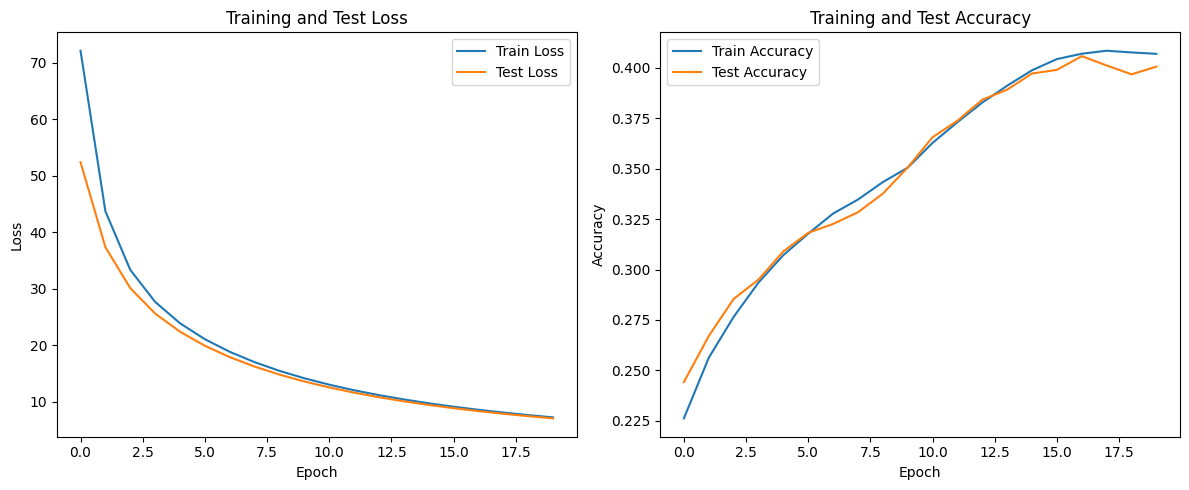

In [139]:

# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [154]:
#show the confusion matrix
predictions = model.predict(test_images, text_embeddings)
cm = confusion_matrix(test_lab, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [143]:
#print the classification report

print(classification_report(test_lab, predictions, target_names=categories))

              precision    recall  f1-score   support

      rabbit       0.30      0.45      0.36      1000
        yoga       0.61      0.08      0.14      1000
        hand       0.42      0.72      0.53      1000
     snowman       0.46      0.76      0.57      1000
   motorbike       0.00      0.00      0.00      1000

    accuracy                           0.40      5000
   macro avg       0.36      0.40      0.32      5000
weighted avg       0.36      0.40      0.32      5000



/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreacristiano/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## Library implementation

In [184]:
train_img = np.load('./quickdraw_subset_np/train_images.npy')
train_labels = np.load('./quickdraw_subset_np/train_labels.npy')
test_img = np.load('./quickdraw_subset_np/test_images.npy')
test_labels = np.load('./quickdraw_subset_np/test_labels.npy')


In [185]:
train_images = train_img.reshape(train_img.shape[0], -1).T / 255.0  # (features, samples)
test_images = test_img.reshape(test_img.shape[0], -1).T / 255.0     # (features, samples)

# Prepare labels (convert to indices if they're strings)
categories = ['rabbit', 'yoga', 'hand', 'snowman', 'motorbike']
category_to_idx = {cat:i for i, cat in enumerate(categories)}


# Prepare word embeddings matrix (categories x 300)
word_embeddings = np.stack([embeddings1[cat] for cat in categories])  # (5, 300)


In [186]:
embedding_dim = 128
image_dim = train_images.shape[0]  # Flattened image size
learning_rate = 0.000001
batch_size = 64
epochs = 20

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images.T, train_labels)).shuffle(10000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_images.T, test_labels)).batch(batch_size)

class JointEmbeddingModel(tf.keras.Model):
    def __init__(self):
        super(JointEmbeddingModel, self).__init__()
        
        # Image embedding network
        self.image_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(embedding_dim, name='image_embedding')
        ])
        
        # Text embedding network (processes word embeddings)
        self.text_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(embedding_dim, name='text_embedding')
        ])
        
        # Fixed word embeddings (we'll use embedding_lookup)
        self.word_embeddings = tf.constant(word_embeddings, dtype=tf.float32)
    
    def call(self, inputs, training=False):
        # Process images
        image_embeddings = self.image_mlp(inputs)  # (batch, embedding_dim)
        
        # Process all category word embeddings
        category_embeddings = self.text_mlp(self.word_embeddings)  # (num_categories, embedding_dim)
        
        # Compute similarity scores (logits)
        logits = tf.matmul(image_embeddings, category_embeddings, transpose_b=True)
        return logits
    
    def compute_embeddings(self, images):
        """Get just the image embeddings for evaluation"""
        return self.image_mlp(images)


In [187]:

# Initialize model
model = JointEmbeddingModel()
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, logits)

# Test step
@tf.function
def test_step(images, labels):
    logits = model(images, training=False)
    test_accuracy(labels, logits)

train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

In [189]:
for epoch in range(epochs):
    # Reset metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
    
    # Train
    for images, labels in train_dataset:
        train_step(images, labels)
    
    # Test
    for images, labels in test_dataset:
        test_step(images, labels)
    
    # Save metrics
    train_loss_history.append(train_loss.result().numpy())
    train_accuracy_history.append(train_accuracy.result().numpy())
    test_accuracy_history.append(test_accuracy.result().numpy())

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result():.4f}, '
        f'Accuracy: {train_accuracy.result() * 100:.2f}%, '
        f'Test Accuracy: {test_accuracy.result() * 100:.2f}%'
    )

Epoch 1, Loss: 0.6986, Accuracy: 74.96%, Test Accuracy: 79.76%
Epoch 2, Loss: 0.4636, Accuracy: 84.07%, Test Accuracy: 82.82%
Epoch 3, Loss: 0.3504, Accuracy: 88.11%, Test Accuracy: 83.08%
Epoch 4, Loss: 0.2678, Accuracy: 90.68%, Test Accuracy: 82.70%
Epoch 5, Loss: 0.2044, Accuracy: 92.78%, Test Accuracy: 82.58%
Epoch 6, Loss: 0.1508, Accuracy: 94.85%, Test Accuracy: 83.96%
Epoch 7, Loss: 0.1000, Accuracy: 96.60%, Test Accuracy: 83.16%
Epoch 8, Loss: 0.0929, Accuracy: 96.76%, Test Accuracy: 82.72%
Epoch 9, Loss: 0.0761, Accuracy: 97.42%, Test Accuracy: 83.48%
Epoch 10, Loss: 0.0682, Accuracy: 97.62%, Test Accuracy: 84.86%
Epoch 11, Loss: 0.0780, Accuracy: 97.25%, Test Accuracy: 84.78%
Epoch 12, Loss: 0.0381, Accuracy: 98.82%, Test Accuracy: 84.58%
Epoch 13, Loss: 0.0274, Accuracy: 99.04%, Test Accuracy: 84.56%
Epoch 14, Loss: 0.0262, Accuracy: 99.08%, Test Accuracy: 84.68%
Epoch 15, Loss: 0.0232, Accuracy: 99.26%, Test Accuracy: 85.50%
Epoch 16, Loss: 0.0367, Accuracy: 98.85%, Test Ac

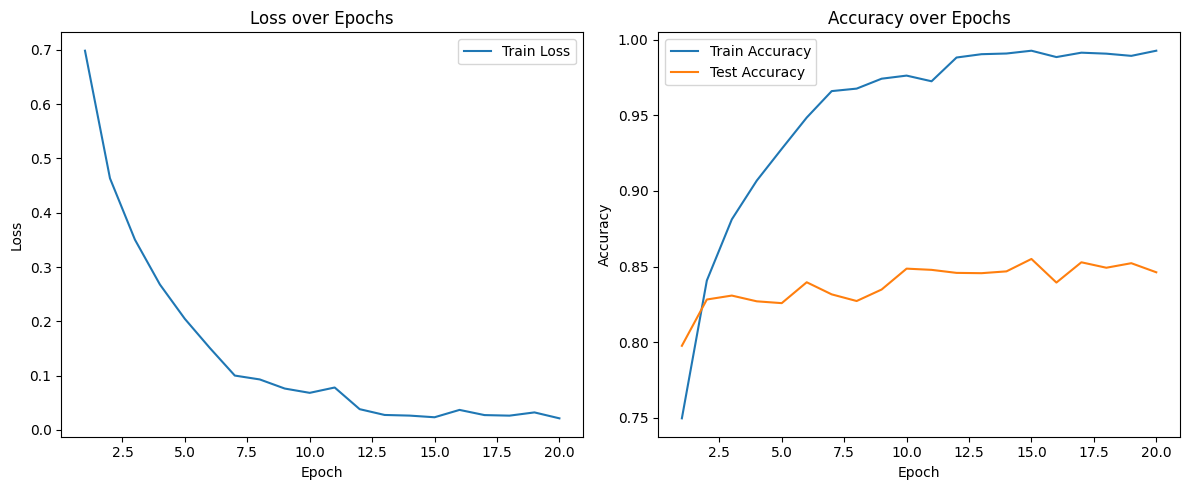

In [190]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs_range, test_accuracy_history, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()